# SuStaIn tutorial using simulated data

Written by Alex Young in April 2020, updated in April 2021. Please email alexandra.young@kcl.ac.uk with any questions.

This tutorial demonstrates how to run Subtype and Stage Inference (SuStaIn) using simulated data. SuStaIn is an unsupervised learning algorithm that identifies subgroups of individuals with distinct biomarker progression patterns. See [Young et al. Nature Communications 2018](https://doi.org/10.1038/s41467-018-05892-0) for more details.

SuStaIn is a generalisable algorithm in which you can choose how to model the progression of biomarkers within a subtype. In this tutorial I use the linear z-score model I used in [Young et al. 2018](https://doi.org/10.1038/s41467-018-05892-0), but it is possible to use other models of biomarker evolution, such as the event-based model.

For a demonstration of the 'event-based'/mixture modelling version of SuStaIn (i.e. MixtureSustain), see simrun.py, available in the /sim subdirectory of the pySuStaIn package.

## Installing SuStaIn and setting it up to run in a notebook

To get SuStaIn up and running first you need to install the package. I'm using Anaconda and had some conflicts with existing packagaes so I had to create a new environment and set it up to be accessible from a jupyter notebook. For me the whole set up process looked like this...

Step 1: Create a new environment "sustain_env" in anaconda that uses python 3.7 and activate the environment ready to install pySuStaIn.
```console
conda create --name sustain_env python=3.7
conda activate sustain_env
```

Step 2: Install pySuStaIn within the environment. The first line installs the kde-ebm (not needed for this tutorial), and the second line installs pySutaIn. Using the -e option enables you to edit the code (most users won't need to do this so can remove the -e). 
```console
pip install -e ./awkde
pip install -e .
```

Step 3: To get the new environment to run inside a notebook I had to install ipykernel and use that to add the environment as a new kernel.
```console
conda install ipykernel
python3.7 -m ipykernel install --user --name sustain_env
```

When running the notebook you then need to make sure you're using the new kernel (it should appear as sustain_env in the top right hand corner, or you need to select it using Kernel>Change kernel>sustain_env).

## Importing packages

In [1]:
# import the python packages needed to generate simulated data for the tutorial
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import sklearn.model_selection
import pandas as pd
import pylab
import sys
import pySuStaIn


#sys.path.insert(0,'../sim/')
#from simfuncs import generate_random_Zscore_sustain_model, generate_data_Zscore_sustain

## The linear z-score model

The linear z-score model I use in this tutorial describes a subtype progression pattern as the linear evolution of biomarkers between different z-scores. Figure 1 below shows an example of what this model looks like for a single subtype. The model is indexed by a set of discrete stages. Each stage corresponds to a biomarker reaching a new z-score from the set of z-scores for each biomarker, Z_vals. Each biomarker starts with a minimum value of 0 at stage 0 and reaches a maximum of Z_max at the final stage of the progression. The number of stages is determined by the number of biomarkers and z-scores in Z_vals. The SuStaIn algorithm identifies subgroups of individuals and their progression patterns - for the linear z-score model the progression pattern would be the ordering of the different biomarker z-scores in Z_vals - gt_sequence below.

You can play around generating different sequences and altering the settings of the linear z-score model using the code below.

## Important note on the linear z-score model

It's natural to think of the progression pattern in Figure 1 as linear in time but this isn't necessarily the case. For example, the time between stages 2 and 3 may be much longer than between stages 8 and 9. This means that the shape of the trajectories may look quite different if indexed by time (although the general order in which the biomarkers progress to different z-scores would remain the same). The linear z-score model simply describes the patient snapshots you would expect to see in a cross-sectional dataset for any particular subtype at a particular stage. The subtypes and stages are considered as hidden variables, which the SuStaIn algorithm identifies directly from the data.

## The SuStaIn algorithm

SuStaIn identifies subtypes with distinct progression patterns from cross-sectional data. The algorithm proceeds hierarchically, first fitting a single subtype to the data, then two, then three, etc., up to a maximum number of subtypes chosen by the user. The fitting of the nth subtype model works but splitting each of the previous n-1 clusters into two and then using this as an initialisation to fit the n subtype model. For each of the n subtype models, SuStaIn uses MCMC sampling to estimate the uncertainty in the subtype progression patterns and the proportion of individuals that belong to each subtype. The optimal number of subtypes is selected by using cross-validation to compute the cross-validation information criterion (CVIC).

## Preparing data for SuStaIn

The data for SuStaIn needs to be z-scored relative to a control population such that the mean of the control population is 0 and the standard deviation of the control population is 1. To do this simply subtract the mean of the control population from your data and divide by the standard deviation of the control population. Double check that if you apply this transformation to the control population only that the control population has a mean of 0 and a standard deviation of 1. The data further needs to be transformed to increase in z-score with disease progression. If the biomarkers you are using decrease with disease progression you need to multiply the data for those biomarkers by -1.

I'd suggest the following workflow for getting your data ready to run SuStaIn on.

1. Regress out the effects of covariates. Learn the effects of covariates in a control population and use this model to regress out the effect of covariates for all the subjects. Learning the model in the control population will avoid regressing out disease effects, which you want to keep in your dataset.

2. Calculate the mean and standard deviation of each biomarker in your control dataset, mean_control and std_control.

3. Z-score your data by taking (data-mean_control)/std_control.

4. Identify any biomarkers that decrease with disease progression, these will have mean_data < mean_control. Multiply the data for these biomarkers by -1.

Steps 2-4 are illustrated in the section below but will have little effect on the simulated data because it is generated as z-scores already.

## Choosing the settings
The SuStaIn algorithm requires the following inputs.

### data
The data you want to run SuStaIn on, of size M subjects by N biomarkers. This needs to be z-scored in the way described in the previous section.

### Z_vals
This is the set of z-scores you want to include for each biomarker. The more z-scores you use the longer the SuStaIn algorithm will take to run. Z_vals has size N biomarkers by Z z-scores. If you have more z-scores for some biomarkers than others you can simply leave zeros at the end of biomarker rows with fewer z-scores.

### Z_max
The maximum z-score reached at the end of the progression, with size N biomarkers by 1. I'd suggest choosing a value around the 95th percentile of your data but you can experiment with different values. I typically choose an integer for interpretability but you don't have to.

### SuStaInLabels
The names of the biomarkers you are using, for plotting purposes.

### N_startpoints
The number of startpoints to use when fitting the subtypes hierarchichally. I'd suggest using 25.

### N_S_max
The maximum number of subtypes to fit. I'd suggest starting with a lower number - maybe three - and then increasing that if you're getting a significantly better fit with the maximum number of subtypes. You can judge this roughly from the MCMC plot. To properly evaluate the optimal number of subtypes you need to run cross-validation.

### N_iterations_MCMC
The number of iterations for the MCMC sampling of the uncertainty in the progression pattern. I'd recommend using 1x10^5 or 1x10^6.

### output_folder
Choose an output folder for the results.

### dataset_name
Name the results files outputted by SuStaIn.

### use_parellel_startpoints
Boolean for whether or not to parallelize the startpoints.

### Additional note
There are approximate and exact versions of the computation of the data likelihood for the linear z-score model. Currently the python version only supports the approximate version. If you want to use the exact version please see the Matlab version at https://github.com/ucl-pond/SuStaInMatlab.

In [2]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though

path = r'H:\pySuStaIn-master\data\ROI_SelectROI_19_Github.xls'  # 参数初始化
data = pd.read_excel(path)  # 读取数据
print(data.describe())
data = data.values

           ACC_sub      ACC_pre      ACC_sup   Precentral_L   Frontal_Sup_L  \
count  1151.000000  1151.000000  1151.000000    1151.000000     1151.000000   
mean      0.183623     0.167877     0.247111       0.158971        0.216146   
std       0.939881     0.947988     0.905208       0.943900        0.921957   
min      -3.390436    -3.042414    -3.390512      -3.149481       -2.878493   
25%      -0.391786    -0.429412    -0.370812      -0.471296       -0.387439   
50%       0.237456     0.142559     0.259368       0.147988        0.209340   
75%       0.827751     0.785702     0.885035       0.751480        0.813859   
max       3.342462     4.284813     2.649311       3.665985        3.908671   

        Frontal_Mid_L     Rectus_L     Insula_L   Cingulate_Mid_L  \
count     1151.000000  1151.000000  1151.000000       1151.000000   
mean         0.165303     0.165182     0.235384          0.178207   
std          0.924773     0.937502     0.962667          0.932606   
min         

In [3]:
# Input the settings for z-score SuStaIn
M       = 1151       # number of subjects
N       = 19         # number of biomarkers
N_S_max = 3     # number of subtypes

N_startpoints = 25                  # usually N_startpoints = 25
N_iterations_MCMC = int(1e5)        # usually N_iterations_MCMC = int(1e5) or int(1e6)

output_folder = os.path.join(os.getcwd(), 'folds_2')
dataset_name = 'output-19-subtype3-Github'

SuStaInLabels           = []
for i in range(N):
        SuStaInLabels.append( 'Biomarker '+str(i)) # labels of biomarkers for plotting
        
Z_vals                  = np.array([[1,1.5,2]]*N)     # Z-scores for each biomarker
Z_max                   = np.array([5]*N)           # maximum z-score

# To demonstrate how to set different biomarkers to have different z-scores,
# set biomarker 0 to have z-scores of 1 and 2 only and a maximum of 3
# to do this change the corresponding row of Z_vals to read 1 2 0
# and change the corresponding row of Z_max to 3
# Z_vals[np.array(0),np.array(2)] = 0
# Z_max[np.array(0)] = 3

# and set biomarker 2 to have a z-score of 1 only and a maximum of 2
# to do this change the corresponding row of Z_vals to read 1 0 0 
# and change the corresponding row of Z_max to 2 
# Z_vals[np.array(2),np.array([1,2])] = 0
# Z_max[np.array(2)] = 2

use_parallel_startpoints = True  # use_parallel_startpoints    - boolean for whether or not to parallelize the maximum likelihood loop

sustain_input = pySuStaIn.ZscoreSustain(data,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              use_parallel_startpoints)

## Create folder for results if it doesn't exist already

In [4]:
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

## Running the SuStaIn algorithm

We're finally ready to run the SuStaIn algorithm! The main outputs are samples_sequence and samples_f. samples_sequence gives MCMC samples of the ordering of the biomarker z-scores for each n subtype model. samples_f gives MCMC samples of the proportion of individuals that belong to each subtype for each n subtype model. These can be found in the outputted files.

In [5]:
# runs the sustain algorithm with the inputs set in sustain_input above
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Found pickle file: H:\pySuStaIn-master\notebooks\folds_2\pickle_files\output220724-19-subtype3-repeat_subtype0.pickle. Using pickled variables for 0 subtype.
Found pickle file: H:\pySuStaIn-master\notebooks\folds_2\pickle_files\output220724-19-subtype3-repeat_subtype1.pickle. Using pickled variables for 1 subtype.
Found pickle file: H:\pySuStaIn-master\notebooks\folds_2\pickle_files\output220724-19-subtype3-repeat_subtype2.pickle. Using pickled variables for 2 subtype.


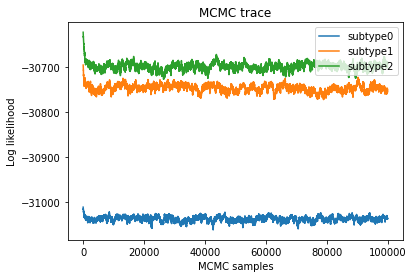

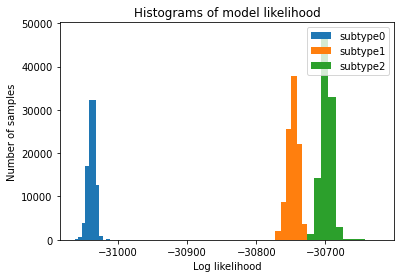

In [6]:
# for each subtype model
import pandas
# for each subtype model
for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pandas.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    plt.savefig(os.path.join(output_folder, 'MCMCtrace-subtype3-Github.png'),dpi=600)
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')
    plt.savefig(os.path.join(output_folder, 'Histograms of model likelihood-subtype3-Github.png'),dpi=600)

# Just added this to demonstrate what happens if you re-run the SuStaIn algorithm 
# with the same dataset name and folder as previously
# The code recognises the files are there already rather than re-running SuStaIn
# This is useful if you want to increase the number of subtypes without 
# starting right from the beginning again
# samples_sequence,   \
# samples_f,          \
# ml_subtype,         \
# prob_ml_subtype,    \
# ml_stage,           \
# prob_ml_stage,      \
# prob_subtype_stage  = sustain_input.run_sustain_algorithm()



## Assessing the output

Now we've run the SuStaIn algorithm, we need to assess the output and decide whether to change any of the settings. 

### MCMC trace

The first thing to look at is the MCMC trace (Figure 5 below). It should be periodic, i.e. with a structure that regularly repeats itself, rather than having long flat sections where it gets stuck at a particular likelihood. If this isn't the case SuStaIn is not working well on your data. There's some troubleshooting you can try:
- Check that your data is z-scored correctly
- Check that the choice of z-scores (Z_vals and Z_max) are sensible
- Check that your data looks normally distributed in your control population
-- if not, try an alternative version of SuStaIn that might be more suitable for your data, e.g. SuStaIn using a KDE event-based model for non normally distributed data 
- Increase the number of startpoints (N_startpoints)
- Increase the number of MCMC samples (N_iterations_MCMC)

### Histograms of model likelihood
The next thing to look at are histograms of the model likelihood (Figure 6 below). Whilst the number of subtypes should be determined through cross-validation, these histograms can give a reasonable indication of the number of subtypes in your dataset, which will enable you to decide whether to fit more subtypes and what to set as the maximum number of subtypes for the cross-validation. When there's a large overlap between the histograms of the model likelihood as you increase the subtypes it means that the likelihood isn't improving very much when you increase the number of subtypes, which means you've probably gone past the optimal number of subtypes. You want to fit enough subtypes so that at least one model is too complex (has too many subtypes) for your data so that you can be sure you've chosen the optimal number of subtypes. If you're not seeing overlapping histograms you need to increase N_S_max and run SuStaIn again from your previous setting of N_S_max.

### Positional variance diagrams
If the end stages of the positional variance diagrams look very blurry with no clear predominant progression pattern, it usually means that there aren't many individuals that fit well with the end stages of the progression. If this is the case you might want to consider removing some biomarker z-scores and re-running SuStaIn.

## Subtyping and staging

Once you've used the CVIC to choose the optimal number of subtypes you can use the SuStaIn output from that subtypes model to subtype and stage individuals in your dataset. This will already have been output by the SuStaIn algorithm, you can extract the outputs using the code below. The outputs are

### ml_subtype and prob_ml_subtype
The maximum likelihood subtype and the probability of that subtype for each individual.

### ml_stage and prob_ml_stage
The maximum likelihood stage and the probability of that stage for each individual.

### prob_subtype, prob_stage and prob_subtype_stage
The probability each individual belongs to each subtype, to each stage, and to each subtype and stage combination.

In [7]:
s = N_S_max-1
pickle_filename_s           = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pickle_filepath             = Path(pickle_filename_s)
pickle_file                 = open(pickle_filename_s, 'rb')
loaded_variables            = pickle.load(pickle_file)
ml_subtype                  = loaded_variables["ml_subtype"]
prob_ml_subtype             = loaded_variables["prob_ml_subtype"]
ml_stage                    = loaded_variables["ml_stage"]
prob_ml_stage               = loaded_variables["prob_ml_stage"]
prob_subtype                = loaded_variables["prob_subtype"]
prob_stage                  = loaded_variables["prob_stage"]
prob_subtype_stage          = loaded_variables["prob_subtype_stage"]
ml_sequence_EM              = loaded_variables["ml_sequence_EM"]
pickle_file.close()    



#************* run SuStaIn to infer subtype sequences and subjects' subtypes/stages estimates
#samples_sequence,   \
#samples_f,          \
#ml_subtype,         \
#prob_ml_subtype,    \
#ml_stage,           \
#prob_ml_stage,      \
#prob_subtype_stage      = sustain_input.run_sustain_algorithm(plot=True)

#save the most likely subtype, the associated subtype probability,
# the most likely stage and the associated stage probability for each subject
inputdata_subj_ids   = list(np.arange(1, M+1).astype('str'))

df                      = pd.DataFrame()
df['subj_id']           = inputdata_subj_ids
df['ml_subtype']        = ml_subtype
df['prob_ml_subtype']   = prob_ml_subtype
df['ml_stage']          = ml_stage
df['prob_ml_stage']     = prob_ml_stage
df['prob_subtype0']     = prob_subtype[:,0]
df['prob_subtype1']     = prob_subtype[:,1]
df['prob_subtype2']     = prob_subtype[:,2]

df.to_csv(os.path.join(output_folder, 'Subject_subtype_stage_estimates-19-subtype3-Github.csv'), index=False)

df2                      = pd.DataFrame(ml_sequence_EM)
df2.to_csv(os.path.join(output_folder, 'ml_sequence_EM-19-subtype3-Github.csv'), index=False) 

FONT_SIZE               = 15


# You can also subtype and stage new data using
# N_samples                       = 1000
# ml_subtype,                  \
# prob_ml_subtype,             \
# ml_stage,                    \
# prob_ml_stage,               \
# prob_subtype,                \
# prob_stage,                  \
# prob_subtype_stage          = sustain_input.subtype_and_stage_individuals_newData(new_data,
#                                                                                   samples_sequence,
#                                                                                   samples_f,
#                                                                                   N_samples)？、、


## Comparison with ground truth

Figure